## Домашнее задание 2

**Вариант 1**

**Выполнила Шарыпина Даша, группа 6382**

### Задание 3

Задача поиска евклидова расстояния между замкнутыми выпуклыми множествами.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, inv, norm
from matplotlib.patches import Polygon, Circle
from matplotlib.collections import PatchCollection

### Polytope Distance

$P = \{ p_1, p_2, ..., p_r\}$

$Q = \{q_1, q_2, ..., q_s\}$

Polytope distance problem: $\min \|p - q\|$

$p = \sum_{i = 1}^r \lambda_i p_i$

$q = \sum_{i = 1}^s \mu_i q_i$

$\lambda_i$ and $\mu_i$ are in $[0, 1]$

quadric program in $n$ variables:

$$\mathrm{minimize} \quad x^TC^TCx$$
$$\mathrm{s.t.} \sum_{i = 1}^r x_i = 1$$
$$\sum_{i = r+1}^n x_i  = 1$$
$$x \geq 0$$

$C = (p_1,..., p_r, -q_1, ..., -q_s)$

$x = (\lambda_1, ..., \lambda_r, \mu_1, ..., \mu_s)$

In [22]:
# points in R^2
p = np.array([(1,1), (3,5), (4,2), (2,0)])
q = np.array([(5,5), (6,7), (7,8), (8,7), (9,4)])

# dim
r = p.shape[0]
s = q.shape[0]
n = r + s

C = np.append(p, -q)

Функция и ее градиент:

In [23]:
def function(x, C):
    return np.dot((x.T).dot(C.T), C.dot(x))

In [24]:
def gradient(x, C):
    D = 2*np.dot(C.T, C)
    return np.dot(D.T, x)

In [25]:
f = lambda x : function(x, C)
fgrad = lambda x : gradient(x, C)
C = np.reshape(C, (-1, 2)).T

Проекция на симплекс:

In [26]:
def simplex_projection(x, s = 1):
    dim = len(x)
    x_sorted = np.sort(x)[::-1]
    ind = np.arange(dim) + 1
    x_cum = np.cumsum(x_sorted)
    cond = (x_sorted - (x_cum - s)/ind) > 0
    n = ind[cond][-1]
    nu = 1./n*(x_cum[n-1] - s)
    return np.clip(x - nu, 0, np.inf)

Проекция вектора делится на две независимые проекции его частей на симплекс:

In [27]:
def projection(x, r, s = 1):
    proj = np.zeros(len(x))
    proj[:r] = simplex_projection(x[:r])
    proj[r:] = simplex_projection(x[r:])
    return proj

Решение задачи минимизации:

In [28]:
fgrad = lambda x : gradient(x, A)
A = C
x_prev = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0])
alpha = 0.1
for i in range(100):
    tmp = x_prev - alpha*fgrad(x_prev)
    x_next = projection(tmp, r)
    alpha = np.dot((x_next - x_prev).T, (fgrad(x_next) - fgrad(x_prev)))/(norm(fgrad(x_next) - fgrad(x_prev))**2)
    x_prev = x_next

# results
ls = x_next[:r] # lambda
ms = x_next[r:] # mu

# calculate points
x1 = np.dot(p.T, ls)
x2 = np.dot(q.T, ms)

Визуализация:

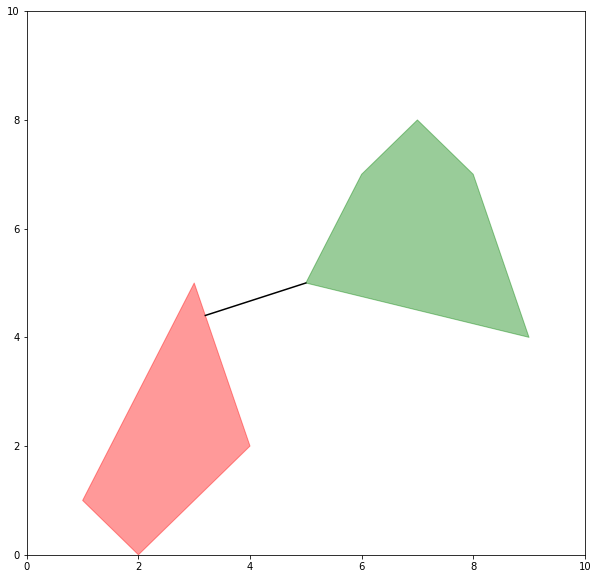

In [29]:
from IPython.core.pylabtools import figsize
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

figsize(10,10)

fig, ax = plt.subplots()
patches = []

ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

patches.append(Polygon(np.array(p), True))
patches.append(Polygon(np.array(q), True))

p = PatchCollection(patches, color=['red', 'green'], alpha=0.4)

plt.plot([x1[0], x2[0]], [x1[1], x2[1]], 'k-')

ax.add_collection(p)
plt.show()

-----------------------

### Линейный классификатор

$f(x, y) = \mathbf{w}^T_y\mathbf{x} + b_y$

1. Обучим классификатор

In [2]:
from sklearn import datasets, metrics
import matplotlib.pyplot as plt

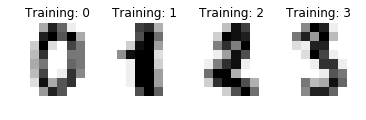

In [3]:
digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

Разделим данные на обучающую и тестовую выборки:

In [4]:
from sklearn.model_selection import train_test_split

nsamples, nx, ny = digits.images.shape
data = digits.images.reshape((nsamples, nx*ny))
labels = digits.target

X, X_test, y, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)


Обучим модель:

In [5]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
classifier.fit(X, y)

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

На тестовых данных:

In [6]:
y_predicted = classifier.predict(X_test)

In [7]:
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)
print(conf_matrix)

[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  1  0  0 44  0  1  0  0  0]
 [ 0  0  1  0  0 44  1  0  0  1]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  1  0  0  0  0  1 38]]


Точность:

In [8]:
accuracy = np.sum(np.diag(conf_matrix))/np.sum(conf_matrix)

print('Accuracy:', accuracy)

Accuracy: 0.9694444444444444


#### Поиск adversarial-примера.

Возьмем в качестве $x_0$ картинку из тестовой выборки, для которой корректно предсказан ее класс:

Predicted class: 4
True class: 4


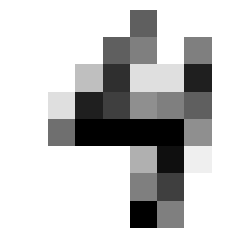

In [9]:
num = 123
print('Predicted class:', y_predicted[num])
print('True class:', y_test[num])

x0 = X_test[num]
image = np.reshape(x0, (8, 8))
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Выбранные параметры:
$x_0$ - картинка, соответствующая классу $y = 4$.

В качестве класса $z$ берем $z = 1$

In [10]:
y = y_predicted[num]
z = 1

Параметры модели:

In [11]:
W = classifier.coef_
b = classifier.intercept_

Задача поиска adversarial-примера:

$$\underset{x}{\min}\|x - x_0\|^2$$

$$\mathrm{s.t.}\quad (\mathbf{w}_z - \mathbf{w}_y)^T\mathbf{x} \geq 0$$
$$\mathbf{x} \in [0, 1]^d$$

Обозначим $u := w_z - w_y$

В стандартной форме ограничение $u^Tx \geq 0$ будет иметь вид $-u^Tx \leq 0$

Лагранжиан:
$$L(x, \lambda) = \|x - x_0\|^2 - \lambda u^T x$$

Условия ККТ:
$$\nabla_x L = 2(x - x_0) - \lambda u = 0$$
$$-u^Tx \leq 0$$
$$-\lambda u^Tx = 0$$
$$\lambda \geq 0$$

При $\lambda = 0$ из первого условия получаем, что $x = x_0$, но мы изначально рассматриваем различные $x$ и $x_0$ по условию задачи.

Тогда $\lambda \neq 0$.

В этом случае из третьего условия получаем, что $u^Tx = 0$. С учетом этого домножим первое условие на $u^T$ и выразим $\lambda$.

Получаем $\lambda = \frac{-2u^Tx_0}{\|u\|^2}$

И тогда $x = x_0 - \frac{u^Tx_0}{\|u\|^2}u$

Тогда получаем, что ограничение, заданное неравенством, можно заменить равенством $u^Tx = 0$. И проекция сводится к задаче проекции на гиперплоскость.

В консексте нашей задачи получаем, что все классы разделены гиперплоскостями и тогда аналитически решением будет вектор $x$, равный проекции исходного вектора $x_0$ на необходимую гиперплоскость $(w_z - w_y)x = 0$.

In [12]:
wy = W[y]
wz = W[z]

Целевая функция $\|x - x_0\|^2$

In [13]:
def objective(x, x0):
    return norm(x - x0)**2

Градиент целевой функции $\nabla f = 2(x - x_0)$

In [14]:
def obj_grad(x, x0):
    return 2*(x - x0)

Проекция на гиперплоскость $u^Tx = 0$

In [15]:
def proj_hyperplane(x, x0, u):
    return x0 - ((np.dot(u.T, x0))/norm(u)**2)*u

Проекция на гиперкуб:

In [16]:
def proj_hypercube(x):
    n  = len(x)
    for i in range(n):
        if x[i] > 1:
            x[i] = 1
        elif x[i] < 0:
            x[i] = 0
    return x

Алгоритм Дейкстры:

In [17]:
def proj_dykstra(v, proj_1, proj_2):
    x = v
    p = np.zeros(v.shape)
    q = np.zeros(v.shape)
    k = 0
    diff = np.inf
    while diff > 1e-4 and k < 100: # YOUR CODE 
        y = proj_1(x + p)
        p = x + p - y
        x_old  = x
        x = proj_2(y + q)
        q =  y + q - x
        
        k = k+1
        diff = norm(x - x_old)
    return x

Алгоритм минимизации:

In [18]:
from scipy.optimize import line_search

def minimize_proj_gd(func, x0, grad, proj = lambda x: x, steepest=False):
    x = x0.copy()
    max_iter = 1e+1
    k=0
    steps = [x]
    x_old = x0*2
    while norm(x - x_old) > 1e-4 and k<max_iter:
        k = k+1
        p = -grad(x) # descent direction
        # exact search
        x_old = x
        if steepest:
            alpha = minimize_scalar(lambda a: func(x + a*p), bounds=(0, np.inf)).x # solve 1-d optimization
        # line-search to enforce strong Wolfe conditions
        else:
            alpha = line_search(func, grad, x, p)[0]       
        x = x + alpha*p
        steps.append(x)
        x = proj(x)
        steps.append(x)
    return x, steps

In [19]:
f = lambda x: objective(x, v)
fgrad = lambda x: obj_grad(x, v)

proj_1 = lambda x: proj_hyperplane(x, v, u)
proj_2 = lambda x: proj_hypercube(x)

projection = lambda x: proj_dykstra(x, proj_1, proj_2)

v = x0
u = wz - wy

In [20]:
x, steps=  minimize_proj_gd(f, np.ones(64,), fgrad, proj = projection)

Результат:

Predicted class: 1
True class: 4
Expected: 1


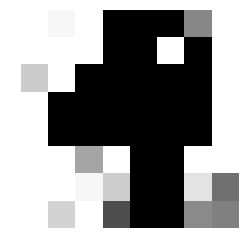

In [21]:
x_noise = x
predict = classifier.predict([x_noise])[0]
print('Predicted class:', predict)
print('True class:', y)
print('Expected:', z)
image = x_noise.reshape(8, 8)
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

--------------------------

2. Для заданного вектора $x_0$ и соответствующего класса $y$ найти вектор $x$, чтобы классификатор относил бы его к любому некорректному классу:

$$\min \|x - x_0\|^2$$
$$\mathrm{s.t.} \quad \exists z \quad (w_z - w_y)^Tx \geq 0$$
$$x \in [0, 1]^d$$

Для этого решить серию оптимизационных задач для всех возможных значений $z \in \{1,..,K\}$, кроме $y$, и выбрать решение с минимальным значением целевой функции.

Predicted class: 5
True class: 5


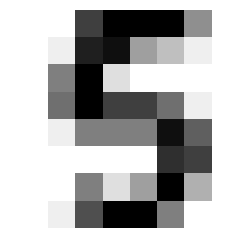

In [35]:
lim = X_test.shape[0]
# random x0

y = 0
pred_y = 1

while y != pred_y:
    x0_ind = np.random.randint(0, lim)
    y = y_test[x0_ind]
    pred_y = y_predicted[x0_ind]


x0 = X_test[x0_ind]

print('Predicted class:', pred_y)
print('True class:', y)

image = x0.reshape(8, 8)
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

# -----------------------

zs = np.arange(0, 10)
zs = np.delete(zs, y)

result = np.zeros(10)
wy = W[y]

xs = np.zeros([10, 64])
f_val = np.zeros(10)


for z in zs:
    wz = W[z]
    proj_1 = lambda x: proj_hyperplane(x, v, u)

    # projection on second constraint
    proj_2 = lambda x: proj_hypercube(x)

    # projection result = projection on intersection of 2 convex sets
    projection = lambda x: proj_dykstra(x, proj_1, proj_2)

    # objective function and its gradient
    f = lambda x : objective(x, v)
    fgrad = lambda x : obj_grad(x, v)

    # minimization
    u = wz - wy
    v = x0
    x1, steps = minimize_proj_gd(f, np.ones(64,), fgrad, projection)
    f_val[z] = f(x1)
    xs[z] = x1

 9


Text(0.5,1,'x_nearest')

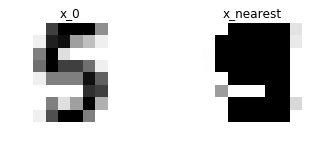

In [36]:
# номер класса, для которого целевая функция минимальна
min_ind = f_val.argsort()[1]
# минимальный x,соответствующий классу min_ind
min_x = xs[min_ind]

for i in range(10):
    h = xs[i]
    plt.imshow(np.reshape(h, (8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')

print("", min_ind)

plt.subplot(2, 2, 1)
plt.axis('off')
plt.imshow(np.reshape(x0, (8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('x_0')
plt.subplot(2, 2, 2)
plt.axis('off')
plt.imshow(np.reshape(min_x, (8, 8)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('x_nearest')

In [37]:
print("Predicted class: ", classifier.predict([min_x])[0])
print("True class: ", y)
print("Expected class: ", min_ind)

Predicted class:  9
True class:  5
Expected class:  9


--------------------

In [4]:
!mkdir ./utils
!curl -o ./utils/simplex_projection.py https://gist.githubusercontent.com/daien/1272551/raw/df474b9c7600cc66d27b6df88d5266d7cb6d9e95/simplex_projection.py

mkdir: невозможно создать каталог «./utils»: Файл существует
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3262  100  3262    0     0   8984      0 --:--:-- --:--:-- --:--:--  9011


In [5]:
!curl -o ./utils/projgrad.py https://raw.githubusercontent.com/andim/projgrad/master/projgrad/main.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6988  100  6988    0     0  14089      0 --:--:-- --:--:-- --:--:-- 14088


-----------------------------------

## Задача 4

#### Robust principal component analysis (RPCA)

$X \approx L + S$

$L$ - low rank matrix ($\mathrm{rank}(L) \leq k$)

$S$ - sparse matrix ($\mathrm{card}(S) \leq r$)

Substitution: $\mathrm{rank}(L) = \|L\|_*$ and $\mathrm{card}(S) = \|\mathrm{vec}(S)\|_1$

So we have optimization problem:

$$\mathrm{min}\frac{1}{2}\|X - L - S\|^2_F$$
$$\mathrm{s.t.} \quad \|L\|_* \leq \gamma, \quad \|\mathrm{vec}(S)\|_1 \leq \lambda$$

Проекция на шар нормы $l_1$

In [3]:
from utils.simplex_projection import euclidean_proj_simplex
def euclidean_proj_l1_ball(v, s=1):
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = euclidean_proj_simplex(u, s=s)
    w *= np.sign(v)
    return w

Проекция на шар ядерной нормы 

In [4]:
def nuclear_norm(A):
    """Nuclear norm of input matrix"""
    return np.sum(np.linalg.svd(A)[1])

In [5]:
def nuclear_projection(A, s=1, shape=None):
    """Projection onto nuclear norm ball."""
    if not shape==None:
        A = A.reshape(shape)
    U, sigma, V = np.linalg.svd(A, full_matrices=False)
    sigma = euclidean_proj_simplex(sigma, s=s)
    if not shape==None:
        return U.dot(np.diag(sigma).dot(V)).flatten()
    else:
        return U.dot(np.diag(sigma).dot(V))

----------------

Алгоритм Франк-Вульфа:

In [7]:
from scipy.sparse.linalg import svds


def FW_algorithm(M, coeff_L, coeff_S, iter_num = 500, verbose = False):
    # Frank-Wolfe algorithm
    m,n = M.shape
    L = np.zeros((m, n))
    S = L
    for k in range(iter_num):
        if verbose == True:
            print("iter num = ", k, "rank(L) = ", np.ndim(L), " | nonzero(S) = ", np.count_nonzero(S))
        X = L + S - M
        proj_nuclear = nuclear_projection(X)
        svec_left, svalues, svec_right = svds(proj_nuclear, k = 1)
        VL = -coeff_L*np.dot(svec_left, svec_right)

        v = X.flatten('F')
        proj_l1 = euclidean_proj_l1_ball(v)
        i = np.where(np.absolute(proj_l1) == np.amax(np.absolute(proj_l1)))[0][0]
        ei = np.zeros((m*n, 1))
        ei[i] = 1
        VS = -np.sign(proj_l1[i])*coeff_S*np.reshape(ei, (m, n), order = 'F')
        
        alpha = 2/(k + 2)

        Lk = L.copy()
        Sk = S.copy()
        L = Lk + alpha*(VL - Lk)
        S = Sk + alpha*(VS - Sk)
    return L, S

Гибридный алгоритм:

In [8]:
def robustPCA(M, coeff_L, coeff_S, iter_num = 500, verbose = False):
    # Frank-Wolfe algorithm with additional step
    m,n = M.shape
    L = np.zeros((m, n))
    S = L
    for k in range(iter_num):
        if verbose == True:
            print("iter num = ", k, "rank(L) = ", np.ndim(L), " | nonzero(S) = ", np.count_nonzero(S))
        X = L + S - M
        proj_nuclear = nuclear_projection(X)
        svec_left, svalues, svec_right = svds(proj_nuclear, k = 1)
        VL = -coeff_L*np.dot(svec_left, svec_right)

        v = X.flatten('F')
        proj_l1 = euclidean_proj_l1_ball(v)
        i = np.where(np.absolute(proj_l1) == np.amax(np.absolute(proj_l1)))[0][0]
        ei = np.zeros((m*n, 1))
        ei[i] = 1
        VS = -np.sign(proj_l1[i])*coeff_S*np.reshape(ei, (m, n), order = 'F')
        
        alpha = 2/(k + 2)

        Lk = L
        Sk = S

        # intermediate step
        L_tmp = Lk + alpha*(VL - Lk)
        S_tmp = Sk + alpha*(VS - Sk)

        # L(k+1) and S(k+1)
        v = L_tmp + S_tmp - M
        v_tmp = v.flatten(order = 'F')
        proj_tmp = euclidean_proj_l1_ball(v_tmp, s = coeff_S)
        v_tmp = S_tmp.flatten(order = 'F') - proj_tmp
        S = np.reshape(euclidean_proj_l1_ball(v_tmp, s = coeff_S), (m, n))
        L = L_tmp
    return L, S

Решение задачи RPCA:

In [117]:
from scipy.io import loadmat

mat = loadmat('mall.mat')

D = mat['D']
frameSize = mat['frameSize']

Y = D.T
height = frameSize[0][0]
width = frameSize[0][1]

print(Y.shape)
print(height, width)

(300, 81920)
256 320


In [118]:
M, N = Y.shape
print(M, N)

300 81920


In [119]:
m = np.mean(Y.flatten());
scale = norm(Y, 'fro');

In [121]:
delta = 1
gamma = delta; 
lmbda = delta*np.sqrt(np.maximum(M,N))

In [122]:
X = Y.copy()
X = (X - m)/scale

In [75]:
X.shape

(300, 81920)

In [123]:
L, S = robustPCA(X, gamma, lmbda, 10)

In [124]:
X_ = X.flatten()
L_ = L.flatten()
S_ = S.flatten()

S_ = X_ - L_

max_val = np.max(np.abs(S_))
idx = S_ < 0.5*max_val

# then obtain the difference between X and L at those tentatively
# identified background locations
differ = X_[idx] - L_[idx]

# we set the threshold at the mean of the difference values plus
# three standard deviations of those difference values and apply it to S
mu = np.mean(differ)
sigma = np.std(differ)

In [125]:
t = 2

threshold_upper = mu + t*sigma
threshold_lower = mu - t*sigma

Smask_ = np.logical_or(S_ > threshold_upper, S_ < threshold_lower)

L_result = L*scale + m
S_result = Smask_.reshape(Y.shape)*255

Результат:

Text(0.5,1,'S - sparse')

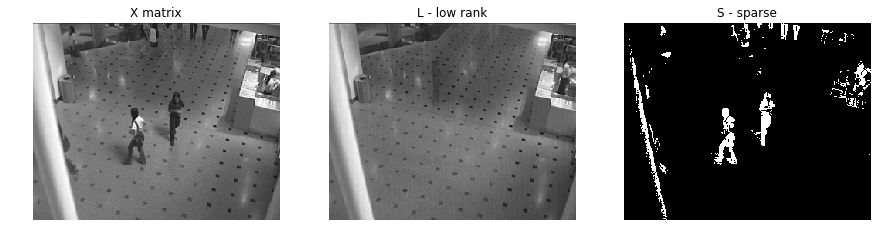

In [133]:
fig = plt.figure(figsize=(15,15))
plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(Y[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('X matrix')
plt.subplot(2, 3, 2)
plt.axis('off')
plt.imshow(L_result[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('L - low rank')
plt.subplot(2, 3, 3)
plt.axis('off')
plt.imshow(S_result[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('S - sparse')

-----------------

График зависимости целевой функции от числа итераций:

In [37]:
n = 500
X = np.random.randn(n, n)

iter_lim = 20
f_vals_hybrid = np.zeros(iter_lim)
f_vals_fw = np.zeros(iter_lim)
for k in range(iter_lim):
    print(k)
    L, S = FW_algorithm(X, gamma, lmbda, iter_num = k)
    f_vals_fw[k] = 0.5*norm(X - L - S, 'fro')**2
    L, S = robustPCA(X, gamma, lmbda, iter_num = k)
    f_vals_hybrid[k] = 0.5*norm(X - L - S, 'fro')**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


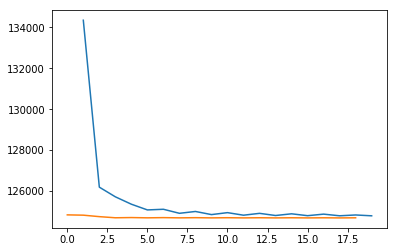

In [42]:
plt.plot(range(1,20), f_vals_fw[1:])
plt.plot(f_vals_hybrid[1:])

---------------------

Упрощенная постановка задачи:

$$\underset{L}{\min}\frac{1}{2}\|X - L\|_F^2$$
$$\mathrm{s.t. rank}(L) \leq k$$

Согласно теореме Эккарта-Янга, она имеет аналитическое решение: $L = U_k \Sigma_k V_k^T$, где $\Sigma_k$ - диагональная матрица, содержащая $k$ старших сингулярных чисел матрицы $X$ на главной диагонали, а $U_k$ и $V_k$ - матрицы с ортонормированной системой из $k$ столбцов - сингулярных векторов, отвечающих старшим сингулярным числам.

$S = X - L$, где $L$ - решение этой задачи.

In [88]:
SVal.shape

(4,)

In [101]:
def simple_RPCA(X, L_rank):
    U, Sval, V = svds(X, k = L_rank)
    return np.dot(U, np.diag(Sval)).dot(V)

In [107]:
L = simple_RPCA(X, 1)

In [108]:
S = X - L

In [109]:
X_ = X.flatten()
L_ = L.flatten()
S_ = S.flatten()

S_ = X_ - L_

max_val = np.max(np.abs(S_))
idx = S_ < 0.5*max_val

# then obtain the difference between X and L at those tentatively
# identified background locations
differ = X_[idx] - L_[idx]

# we set the threshold at the mean of the difference values plus
# three standard deviations of those difference values and apply it to S
mu = np.mean(differ)
sigma = np.std(differ)

In [110]:
t = 2

threshold_upper = mu + t*sigma
threshold_lower = mu - t*sigma

Smask_ = np.logical_or(S_ > threshold_upper, S_ < threshold_lower)

L_result = L*scale + m
S_result = Smask_.reshape(Y.shape)*255

Text(0.5,1,'S - sparse')

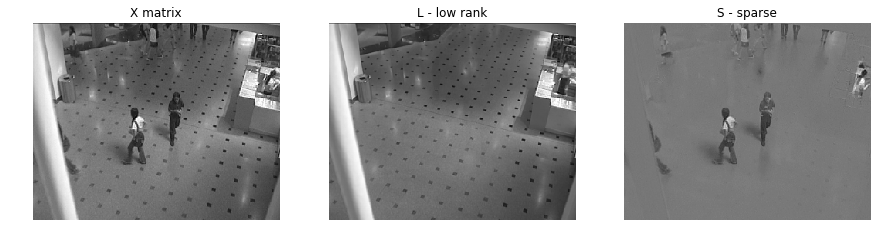

In [116]:
fig = plt.figure(figsize=(15,15))
plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(Y[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('X matrix')
plt.subplot(2, 3, 2)
plt.axis('off')
plt.imshow(L_result[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('L - low rank')
plt.subplot(2, 3, 3)
plt.axis('off')
plt.imshow(S[100,:].reshape(width, height).T, cmap=plt.cm.gray)
plt.title('S - sparse')
#plt.subplot(2, 4, 4)
#plt.axis('off')
#plt.imshow(S_result[100,:].reshape(width, height).T, cmap=plt.cm.gray)
#plt.title('Mask')

-------------------------

In [51]:
!pip install librosa

    100% |████████████████████████████████| 1.6MB 246kB/s ta 0:00:011
    100% |████████████████████████████████| 286kB 225kB/s ta 0:00:011
    100% |████████████████████████████████| 327kB 1.9MB/s ta 0:00:011
  Stored in directory: /home/dasha/.cache/pip/wheels/ce/49/68/87ba660f30e3977f0778e39ee2e944629cd37c2a0ce41f9ff1
  Stored in directory: /home/dasha/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Stored in directory: /home/dasha/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy
